### Research into existing image-stitching Pipeline

#### Typical Usage

Status: 0


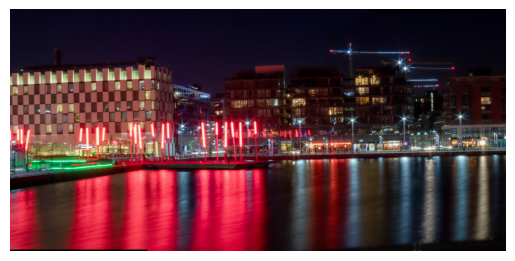

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgs = [cv2.imread(p) for p in (
    '../sample/sample3/GrandCanal_Pano-1.jpg',
    '../sample/sample3/GrandCanal_Pano-2.jpg'
)]

stitcher = cv2.Stitcher_create(cv2.Stitcher_SCANS)
status, pano = stitcher.stitch(imgs)


print("Status:", status)

if status != cv2.Stitcher_OK:
    raise RuntimeError(f"Stitching failed with status {status}")


plt.imshow(cv2.cvtColor(pano, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

### Pipeline Broken Down
#### Feature Detection (SIFT) 

**SIFT**: SIFT stands for Scale Invariant Feature Transform  
When stitching images you have to answer 'What pixel in Image A corresponds to what pixel in Image B?'  
But pixels change when the camera moves, or the image is zoomed, or lighting changes etc. SIFT solves this by finding stable, distinctive features.  

**Keypoints**: a key point is a special spot in an image that is easy to recognise again from another angle. if two images overlap, keypoints in the overlapping area should match.  
Some examples:
- corners of buildings
- window corners
- edges that intersect
- distinct dots or symbols
- unique texture patterns  

the following are not good examples because these areas look the same everywhere:
- sky
- flat walls
- water
- grass  

**Descriptors**: a discriptor is a vector of 128 numbers that describes the texture around a keypoint.
- keypoint: WHERE is this interesting thing?
- descriptor: WHAT does this interesting thing look like?  
Theyre needed because you cant match raw pixel data. noise, lighting, exposure all change. descriptors remain stable across:
- rotation
- scale changes
- lighting differences  




In [ ]:
# scaled the images because otherwise it would take too long
scaled_imgs = [cv2.resize(img, None, fx=0.3, fy=0.3) for img in imgs]

# if it still takes really long uncomment this to limit it to 2000 keypoints
# sift = cv2.SIFT_create(nfeatures=2000)
sift = cv2.SIFT_create(nfeatures=2000)

keypoints = []
descriptors = []

for img in imgs:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)


for i, kp in enumerate(keypoints):
    print(f"Image {i}: {len(kp)} keypoints")

Image 0: 17535 keypoints
Image 1: 26490 keypoints


#### Matching (BFMatcher)

Matching connects a keypoint from image A to a keypoint from image B is the descriptors are similar.  
It compares descriptor vectors using Euclidean distance:
- low distance -> similar = match
- high distance -> different = ignore

In [7]:
bf = cv2.BFMatcher()

# k=2 returns best and second-best match
raw_matches = bf.knnMatch(descriptors[0], descriptors[1], k=2)

good_matches = []
for m, n in raw_matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Total raw matches: {len(raw_matches)}")
print(f"Good matches after ratio test: {len(good_matches)}")

# Print some example distances
print("\nExamples of match distances:")
for i in range(5):
    print(f" Match {i}: dist={raw_matches[i][0].distance:.2f}, ",
          f"second-best={raw_matches[i][1].distance:.2f}")


Total raw matches: 17535
Good matches after ratio test: 3140

Examples of match distances:
 Match 0: dist=306.85,  second-best=325.36
 Match 1: dist=310.68,  second-best=329.46
 Match 2: dist=317.93,  second-best=322.47
 Match 3: dist=259.86,  second-best=310.68
 Match 4: dist=294.04,  second-best=296.89


#### Homography (RANSAC)

Homography is a 3x3 matrix that transforms image B into image A's coordinate system.  
This is where false matches are filtered out, geometric transformations are computed, and how it finds how image B must be 'warped' to align with image A